# Metrics Evaluation
Copyright (c) 2018 Eric Kerfoot, see LICENSE file

This notebook is for computing the area, dimension, thickness, and phase metrics on segmentations inferred from the test data set. It is expected that the `STACOMTrain` notebook has already been run to completion for one trained model and that a `testresults.npz` file exists in a training directory. 

### Import and define useful values:

In [3]:
%matplotlib inline
from __future__ import print_function,division
import os, sys, glob
import numpy as np

import matplotlib.pyplot as plt


from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

import metrics

dat=np.load(glob.glob('./*/testresults.npz')[-1]) # most recent instance of this file
allpreds=dat['results']

numImagesPerSub=20

### These are used to visualize comparisons for each metric:

In [4]:
def pearsonGrid(vals):
    '''Generate a grid of Pearson correlation values between each pair of test subjects given the per-subject values `vals'.'''
    @np.vectorize
    def func(i,j):
        return metrics.pearson(vals[int(i)],vals[int(j)])
    
    return np.fromfunction(func,(vals.shape[0],)*2)
        

linestyles = ['-','--', ':']

def compareResults(results):
    '''Generate comparison subplots'''
    f=plt.figure(figsize=(20,5*results.shape[0]))
    
    for i,res in enumerate(results):
        pgrid=pearsonGrid(res)

        plt.subplot(results.shape[0],2,1+i*2)
        plt.imshow(pgrid,vmin=-1,vmax=1)

        plt.subplot(results.shape[0],2,2+i*2)
        
        for r in range(res.shape[0]):
            plt.plot(res[r],c='C%i'%(r%10),ls=linestyles[(r//10)%len(linestyles)],label=str(r))

        plt.legend(loc=2,bbox_to_anchor=(1,1),ncol=3)
        
        
def graphSubsets(results,titles=None,*subsetinds):
    '''Graph subsets of the results.'''
    f=plt.figure(figsize=(20,5))
    
    for i,subset in enumerate(subsetinds):
        plt.subplot(1,len(subsetinds),1+i)
        
        for ind in subset:
            plt.plot(results[ind],label=str(ind))
        
        plt.legend(loc=2,bbox_to_anchor=(1,1),ncol=1)
        if titles:
            plt.title(titles[i])
        
        
def resizeToSub(arr):
    '''Resize array `arr' so that the last dimension is the size of the image number per subject.'''
    return arr.reshape((arr.shape[0],-1,numImagesPerSub))

### Calculate myocardial and cavity areas:

(2, 30, 20)


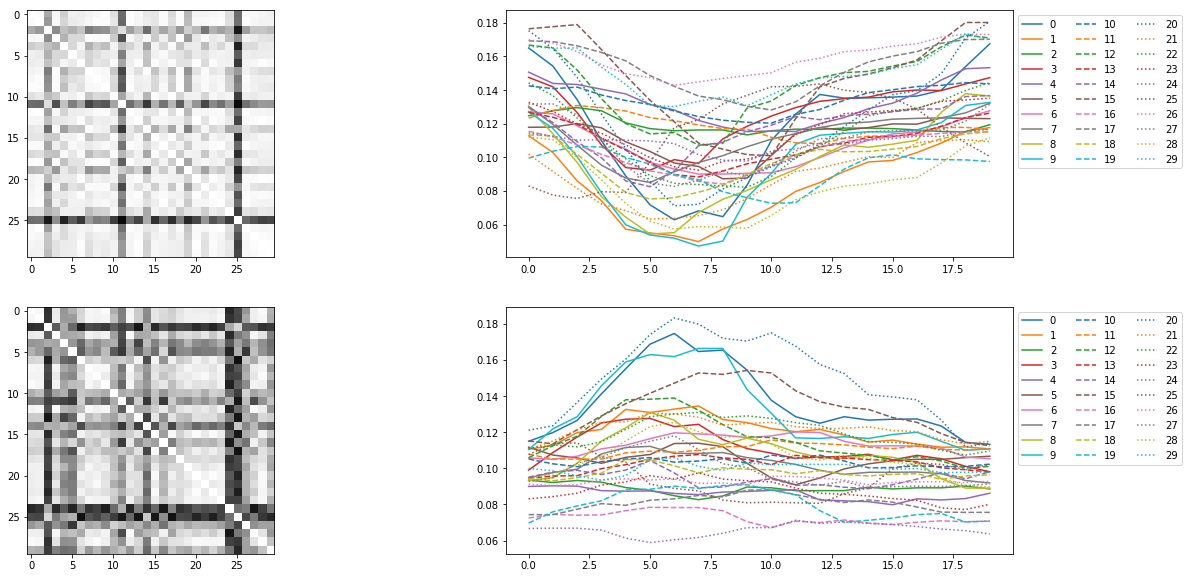

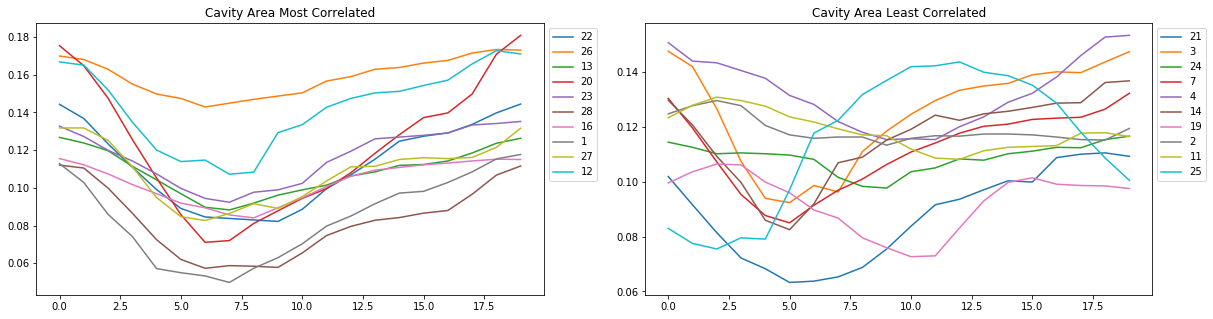

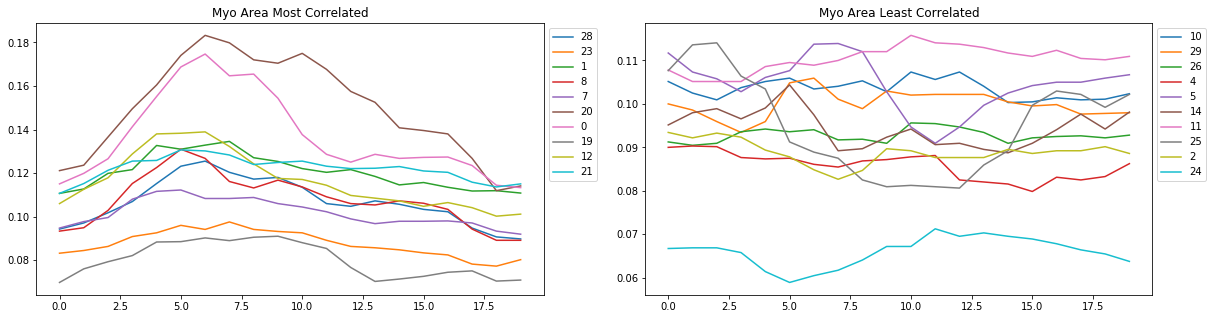

In [6]:
areas=metrics.calculateAreas(allpreds)
areas1=resizeToSub(areas)
print(areas1.shape)

compareResults(areas1)

for i in range(areas1.shape[0]):
    pgrid=pearsonGrid(areas1[i])
    pmean=np.argsort(-pgrid.mean(axis=0))
    atype='Myo' if i else 'Cavity'
    graphSubsets(areas1[i],['%s Area Most Correlated'%atype,'%s Area Least Correlated'%atype],pmean[:10],pmean[-10:])

### Calculate cavity dimensions:

(3, 30, 20)


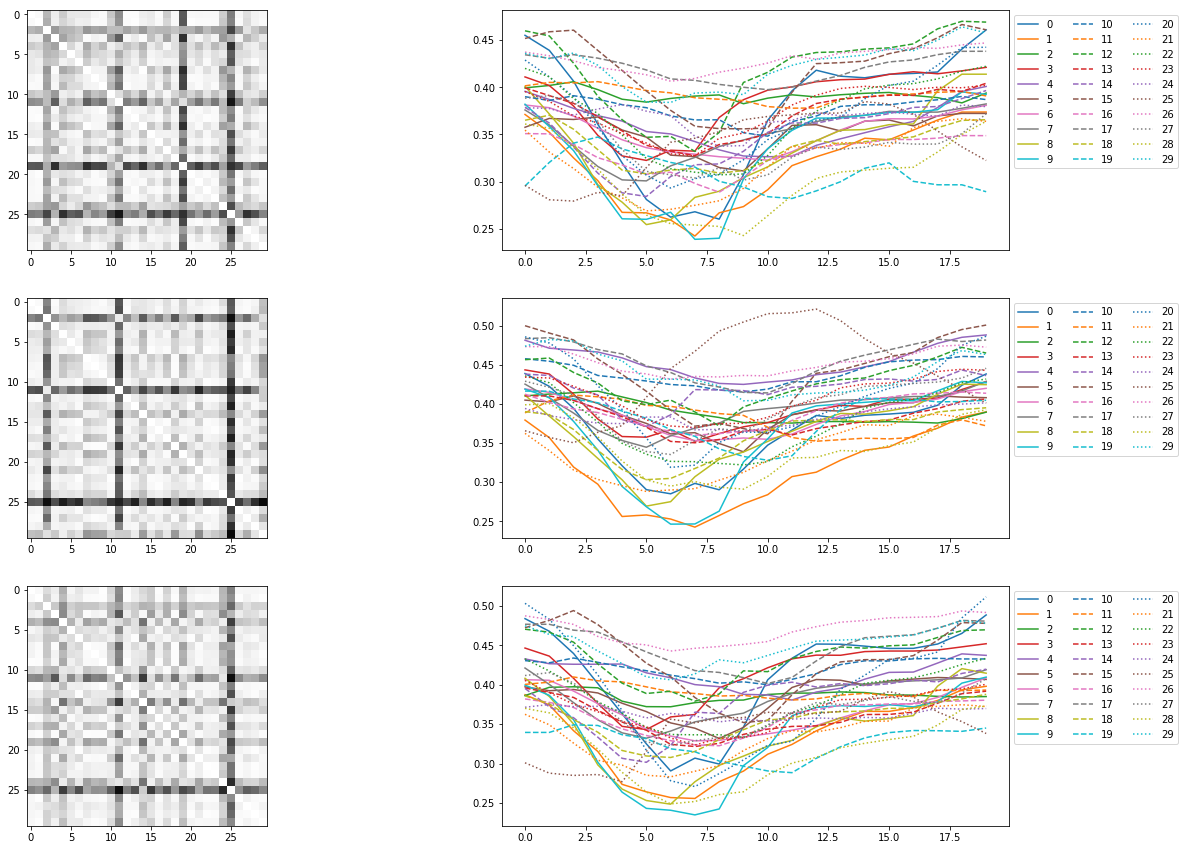

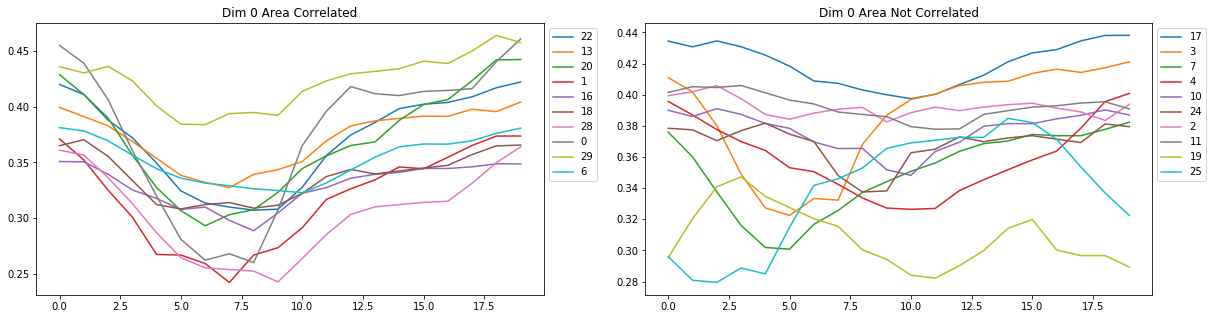

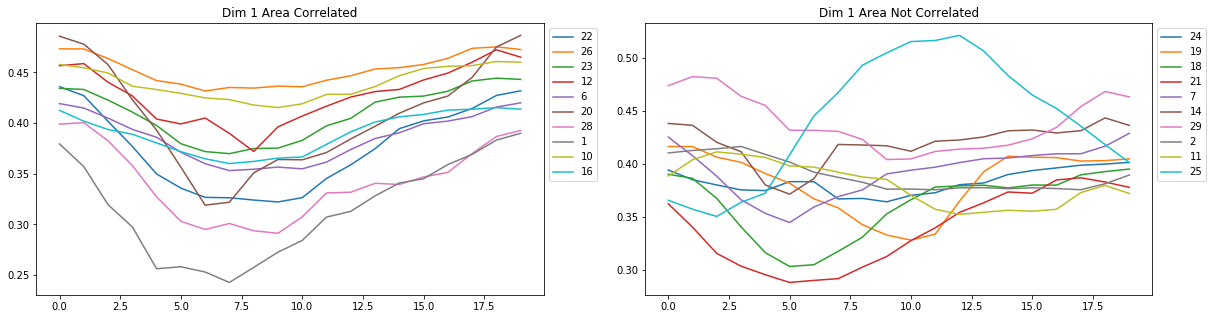

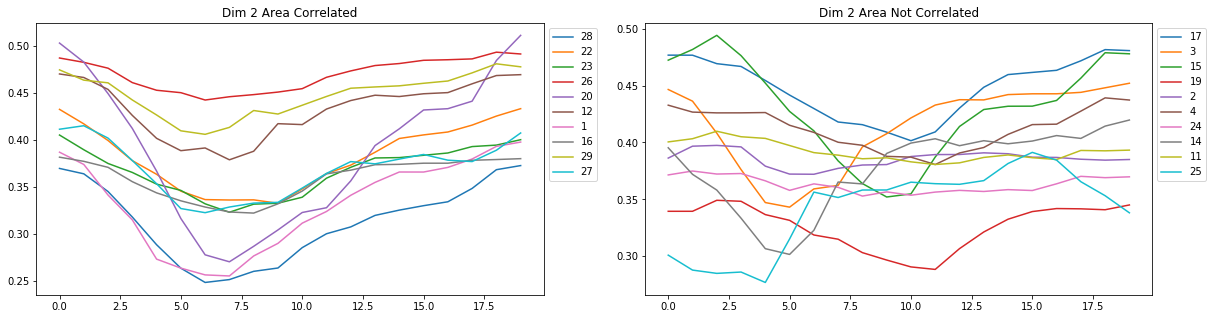

In [7]:
dims=metrics.calculateCavityDims(allpreds)
dims1=resizeToSub(dims)
print(dims1.shape)

compareResults(dims1)

for i in range(dims1.shape[0]):
    pgrid=pearsonGrid(dims1[i])
    pmean=np.argsort(-pgrid.mean(axis=0))
    graphSubsets(dims1[i],['Dim %i Area Correlated'%i,'Dim %i Area Not Correlated'%i],pmean[:10],pmean[-10:])

### Calculate myocardial thicknesses:

(6, 30, 20)


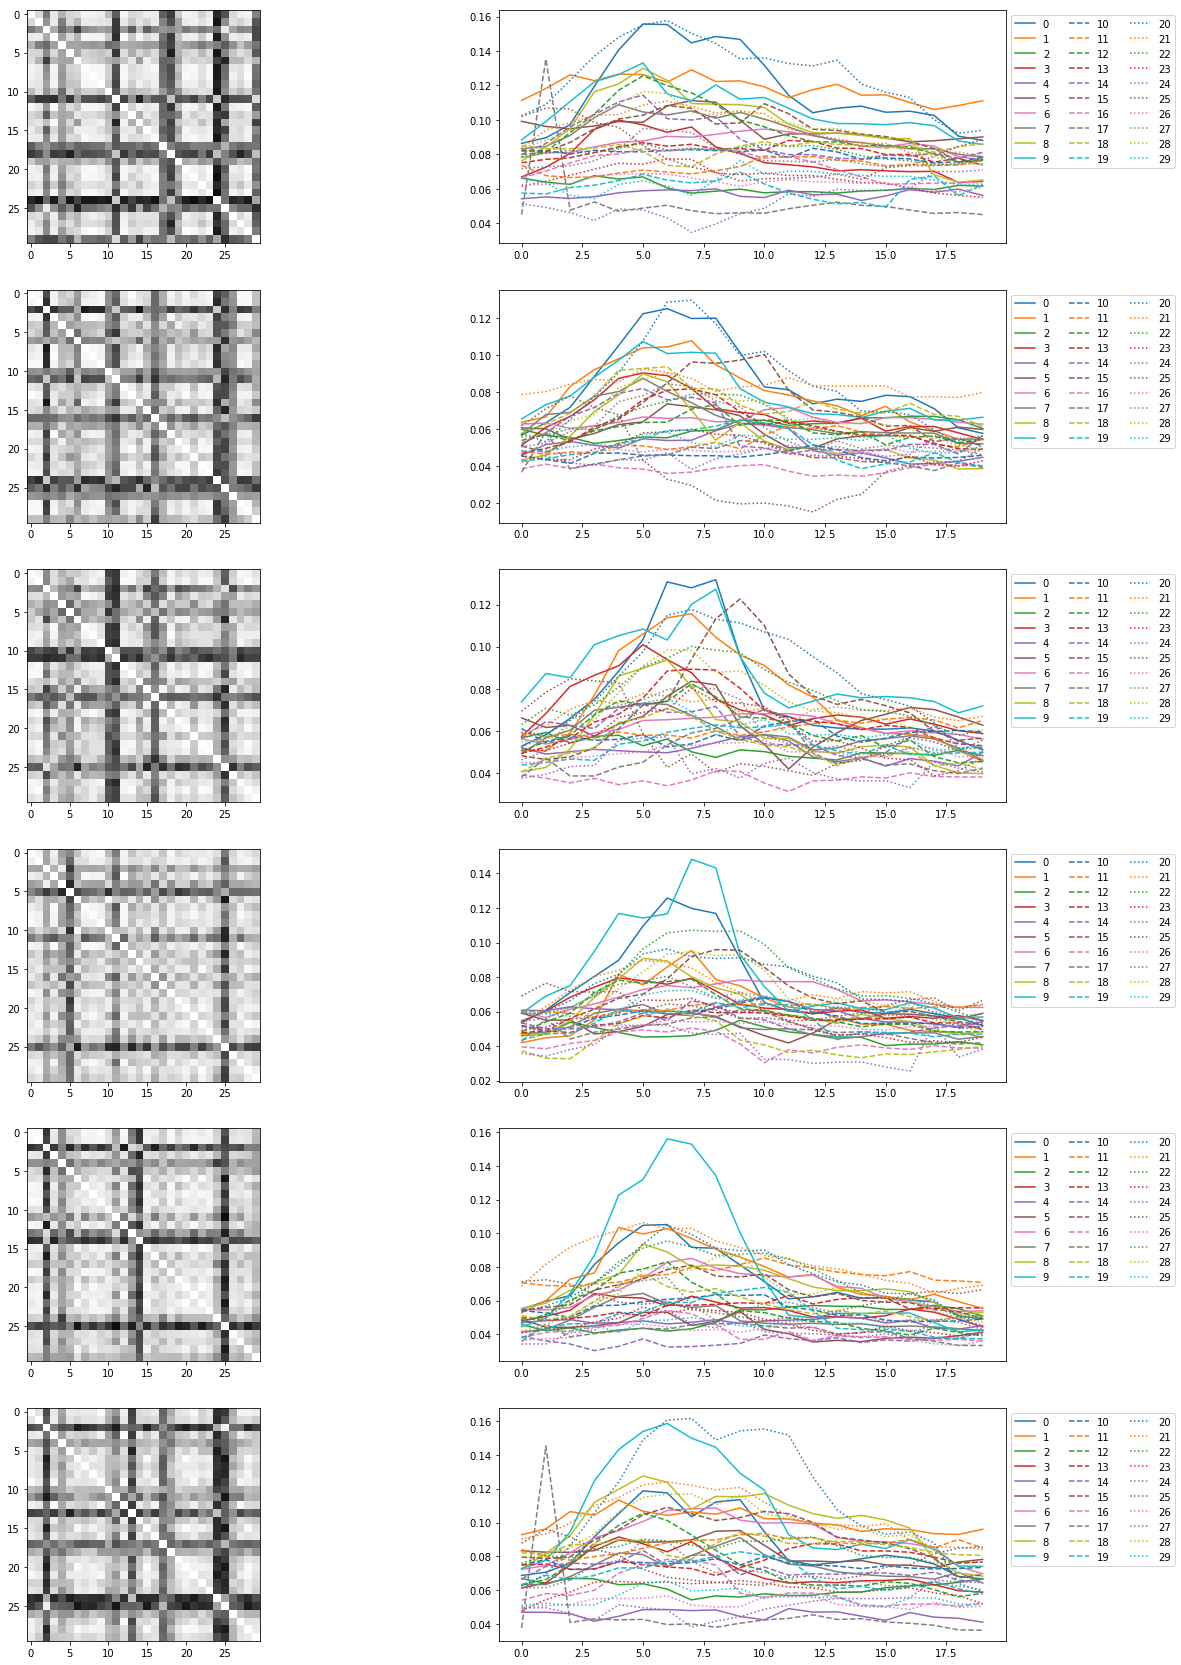

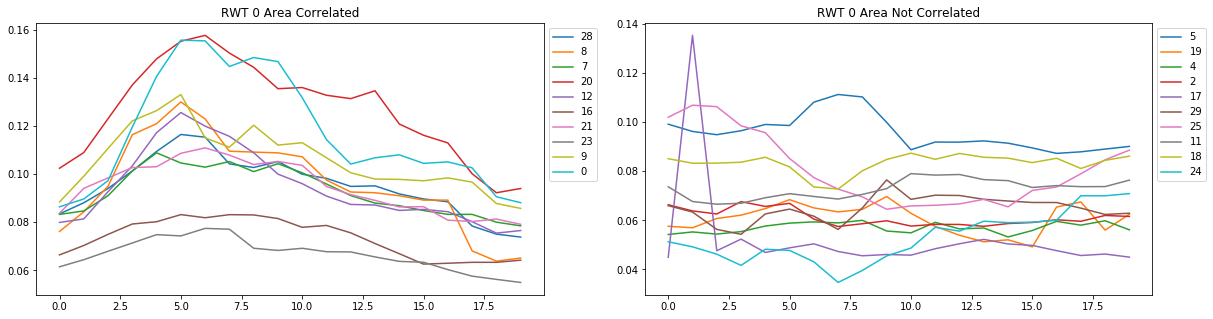

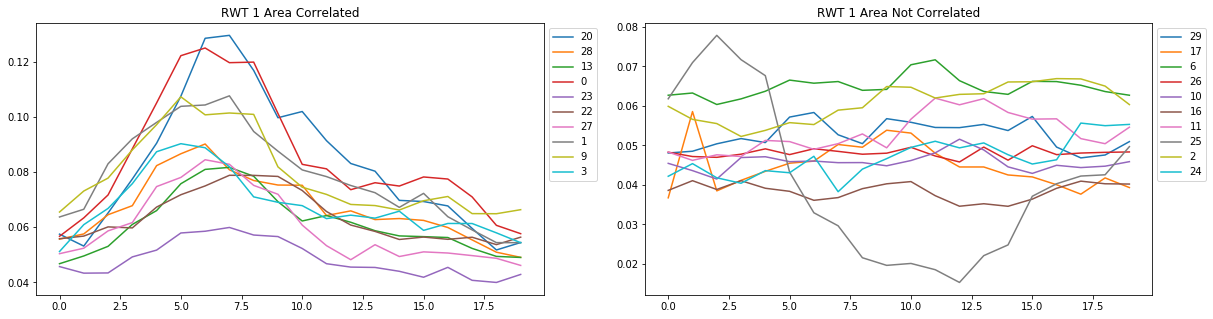

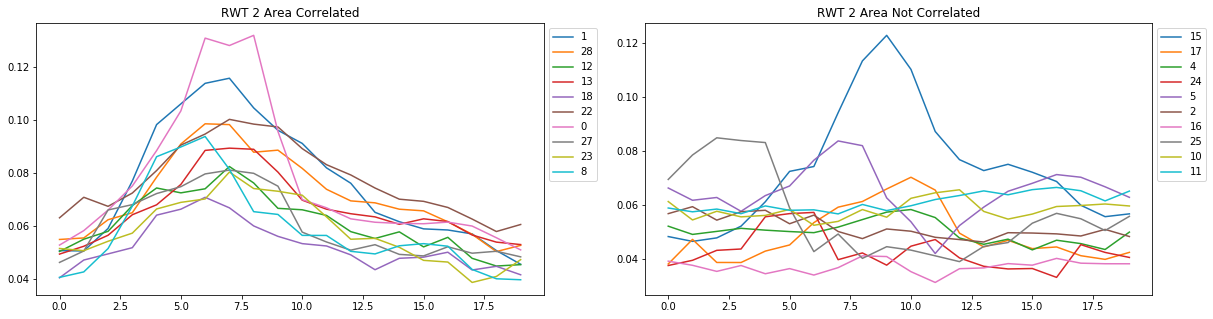

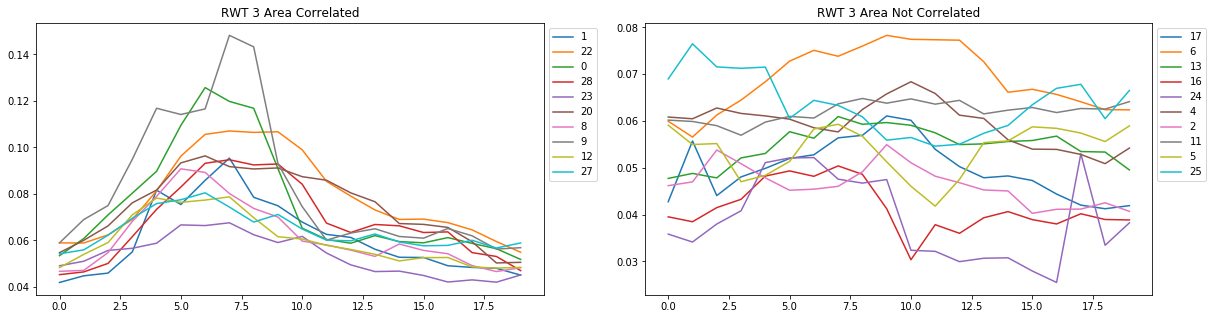

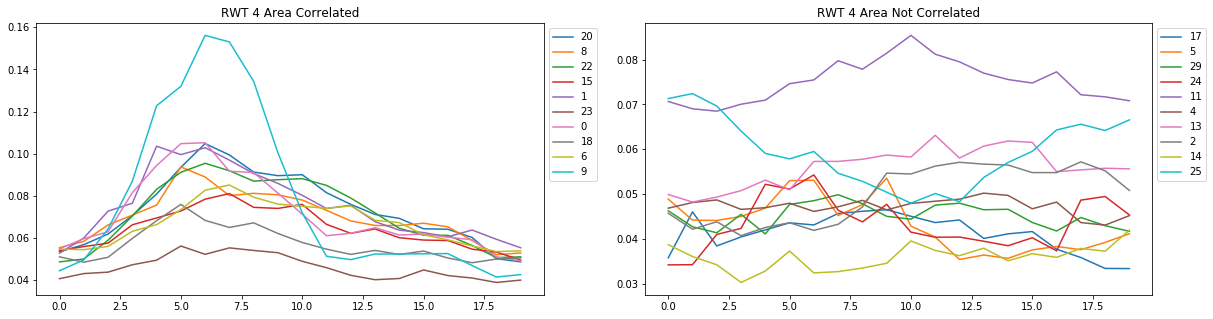

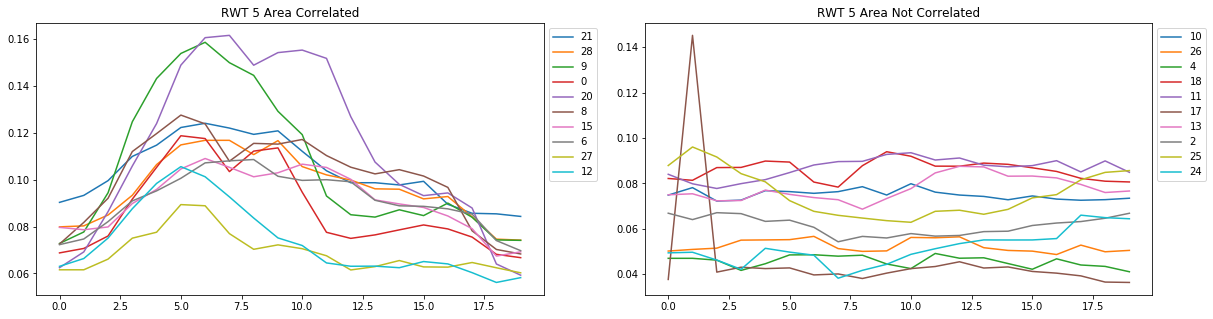

In [8]:
rwt=metrics.calculateWallThicknesses(allpreds)
rwt1=resizeToSub(rwt)
print(rwt1.shape)

compareResults(rwt1)

for i in range(rwt1.shape[0]):
    pgrid=pearsonGrid(rwt1[i])
    pmean=np.argsort(-pgrid.mean(axis=0))
    graphSubsets(rwt1[i],['RWT %i Area Correlated'%i,'RWT %i Area Not Correlated'%i],pmean[:10],pmean[-10:])

### Calculate phase assignments:

(30, 20)


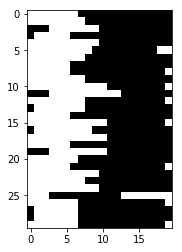

In [9]:
phase=metrics.calculatePhases(areas[0])
phase1=phase.reshape((phase.shape[0]//numImagesPerSub,numImagesPerSub))

print(phase1.shape)

plt.imshow(phase1)

### Write results to file in the submission format:

In [10]:
print(areas.shape,dims.shape,rwt.shape,phase.shape)

with open('testmetrics.txt','w') as o:
     for i in range(areas.shape[1]):
            
        rline=tuple(areas[:,i])+tuple(dims[:,i])+tuple(rwt[:,i])
        name='sub-%.2i-%.2i'%(i//numImagesPerSub,i%numImagesPerSub)
        
        print('%s: %s, %i'%(name,', '.join('%15.15f'%r for r in rline),phase[i]),file=o)


(2, 600) (3, 600) (6, 600) (600,)
